In [1]:
using Distributions
using FastGaussQuadrature
using Interpolations
using Plots
using Random
using Trapz

# Two Periods

## One Bidder - Value Function

In [2]:
function invhaz(D,x)
    return (1-cdf(D,x))/pdf(D,x)
end

function V1(θ1,θ0,γ,δ,G,H,M)
    ψ0 = invhaz(G,θ0)
    sell_value = θ1-ψ0*γ
    value = max(sell_value,0)
    return value
end

function V0(θ0,γ,δ,G,H,M)
    ψ0 = invhaz(G,θ0)
    α, ω = gausshermite(M)
    sell_value = θ0-ψ0
    wait_value = 0
    for i in 1:M
        wait_value = wait_value+ω[i]*V1(γ*θ0+mean(H)+sqrt(2)*std(H)*α[i],θ0,γ,δ,G,H,M)
    end
    wait_value = δ*wait_value/sqrt(π)
    value = max(sell_value,wait_value)
    return value
end

V0 (generic function with 1 method)

In [3]:
γ = 0.9
δ = 0.95

G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

M = 21

21

In [4]:
θ0_grid = LinRange(0.0,2.0,401)
V0_grid = zeros(length(θ0_grid))
for i in 1:length(θ0_grid)
    V0_grid[i] = V0(θ0_grid[i],γ,δ,G,H,M)
end

α, ω = gausshermite(M)
EV = 0
for i in 1:M
    EV = EV+ω[i]*V0(mean(G)+sqrt(2)*std(G)*α[i],γ,δ,G,H,M)
end
EV = EV/sqrt(π)

print("quad: ",EV,"\n")
print("trap: ",trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid)))

plot(θ0_grid,V0_grid,title="Value Function",xlab="θ0",ylab="V0",label=:false,legend=:topleft)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N1T1.png")

quad: 0.6793785529171442
trap: 0.676846259696936

## One Bidder - Simulate Auction

In [5]:
function simulate_auction(n_sims,γ,δ,G,H,M)
    sell_times = zeros(n_sims)
    sell_values = zeros(n_sims)
    for i in 1:n_sims
        θ0 = rand(G,1)[1]
        ψ0 = invhaz(G,θ0)
        α, ω = gausshermite(M)
        sell_value = θ0-ψ0
        wait_value = 0
        for i in 1:M
            wait_value = wait_value+ω[i]*V1(γ*θ0+mean(H)+sqrt(2)*std(H)*α[i],θ0,γ,δ,G,H,M)
        end
        wait_value = δ*wait_value/sqrt(π)
        if sell_value > wait_value
            sell_times[i] = 0
            sell_values[i] = sell_value
        else
            θ1 = γ*θ0+rand(H,1)[1]
            sell_values[i] = δ*V1(θ1,θ0,γ,δ,G,H,M)
            if (sell_values[i] == 0) 
                sell_times[i] = -1
            else
                sell_times[i] = 1
            end
        end
    end
    return sell_times, sell_values
end

simulate_auction (generic function with 1 method)

In [6]:
Random.seed!(1)

n_sims = 1000000
sell_times, sell_values = simulate_auction(n_sims,γ,δ,G,H,M)

sell_values_0 = sell_values[findall(sell_times.==0)]
sell_values_1 = sell_values[findall(sell_times.!=0)]

print(mean(sell_values),"\n")
print(length(sell_values_1)/n_sims,"\n")

histogram(sell_values_0,bins=50,title="Revenue Distribution",xlab="Revenue",ylab="Frequency",label="sold at t=0")
histogram!(sell_values_1,bins=30,label="sold at t=1 or not sold")
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N1T1sim.png")

0.6763467541765066
0.173159


## One Bidder - Comparative Statics - Value Function

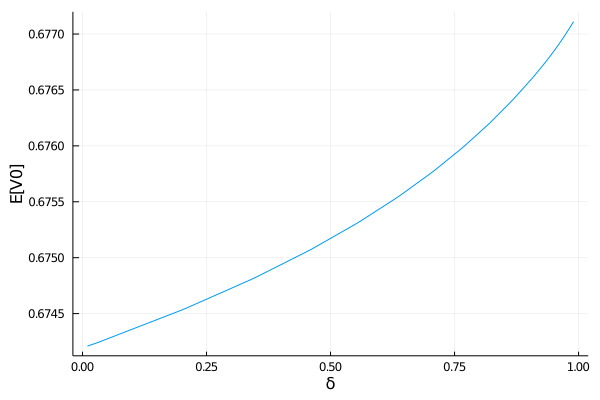

In [7]:
δ_grid = LinRange(0.01,0.99,99)
EV_grid = zeros(length(δ_grid))
for i in 1:length(δ_grid) 
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ,δ_grid[i],G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csδ = plot(δ_grid,EV_grid,xlab="δ",ylab="E[V0]",legend=:false)

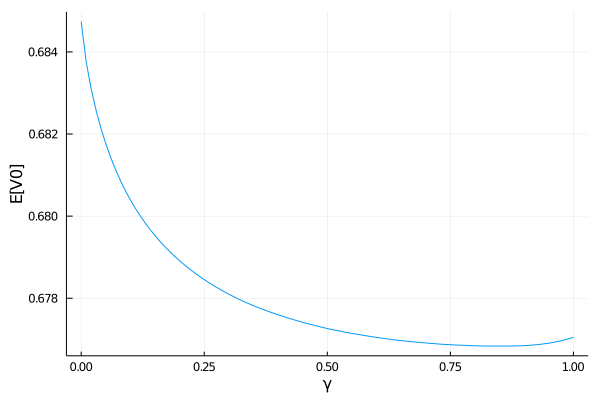

In [8]:
γ_grid = LinRange(0,1,100)
EV_grid = zeros(length(γ_grid))
for i in 1:length(γ_grid) 
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ_grid[i],δ,G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csγ = plot(γ_grid,EV_grid,xlab="γ",ylab="E[V0]",legend=:false)

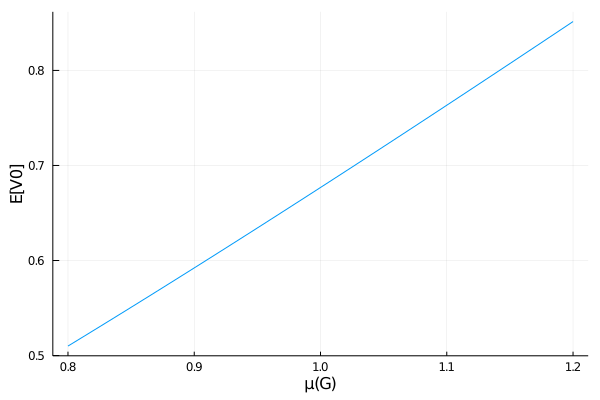

In [9]:
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

μG_grid = LinRange(0.8,1.2,41)
EV_grid = zeros(length(μG_grid))
for i in 1:length(μG_grid) 
    G = Normal(μG_grid[i],0.2)
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ,δ,G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csμG = plot(μG_grid,EV_grid,xlab="μ(G)",ylab="E[V0]",legend=:false)

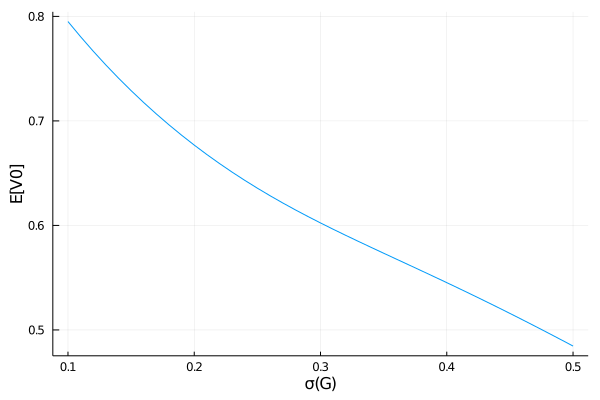

In [10]:
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

σG_grid = LinRange(0.1,0.5,41)
EV_grid = zeros(length(σG_grid))
for i in 1:length(σG_grid) 
    G = Normal(1,σG_grid[i])
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ,δ,G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csσG = plot(σG_grid,EV_grid,xlab="σ(G)",ylab="E[V0]",legend=:false)

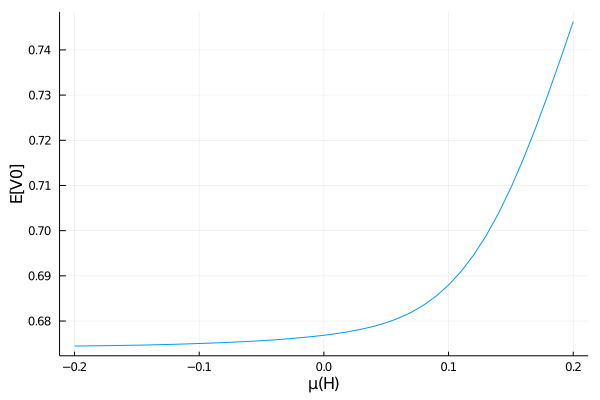

In [11]:
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

μH_grid = LinRange(-0.2,0.2,41)
EV_grid = zeros(length(μH_grid))
for i in 1:length(μH_grid) 
    H = Normal(μH_grid[i],0.2)
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ,δ,G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csμH = plot(μH_grid,EV_grid,xlab="μ(H)",ylab="E[V0]",legend=:false)

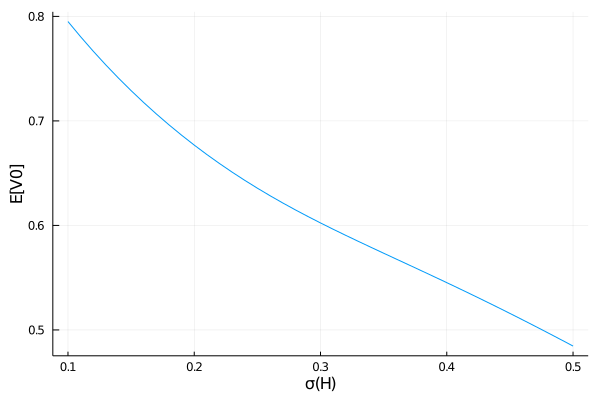

In [12]:
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

σH_grid = LinRange(0.1,0.5,41)
EV_grid = zeros(length(σH_grid))
for i in 1:length(σH_grid) 
    G = Normal(1,σH_grid[i])
    θ0_grid = LinRange(0.0,2.0,801)
    V0_grid = zeros(length(θ0_grid))
    for j in 1:length(θ0_grid)
        V0_grid[j] = V0(θ0_grid[j],γ,δ,G,H,M)
    end
    EV_grid[i] = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
end
csσH = plot(σH_grid,EV_grid,xlab="σ(H)",ylab="E[V0]",legend=:false)

In [13]:
l = @layout [ a b ; c d ; e f ]
plot(csδ,csγ,csμG,csσG,csμH,csσH,layout=l)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N1T1cs.png")

## One Bidder - Comparative Statics - Simulate Auction

In [14]:
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)
M = 11
n_sims = 100000

100000

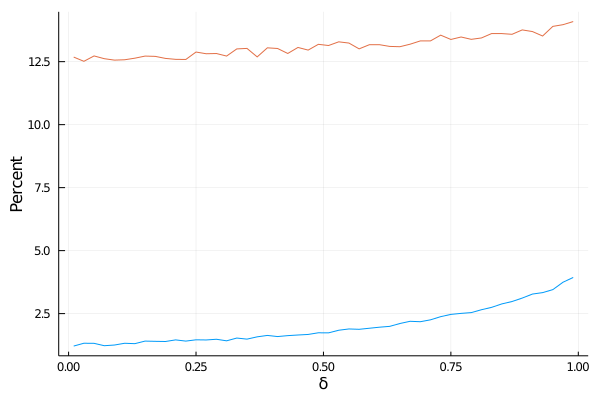

In [15]:
Random.seed!(2)

δ_grid = LinRange(0.01,0.99,50)
T1_grid = zeros(length(δ_grid))
TX_grid = zeros(length(δ_grid))
for i in 1:length(δ_grid) 
    sell_times, sell_values = simulate_auction(n_sims,γ,δ_grid[i],G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csδ = plot(δ_grid,T1_grid,xlab="δ",ylab="Percent",legend=:false)
csδ = plot!(δ_grid,TX_grid)

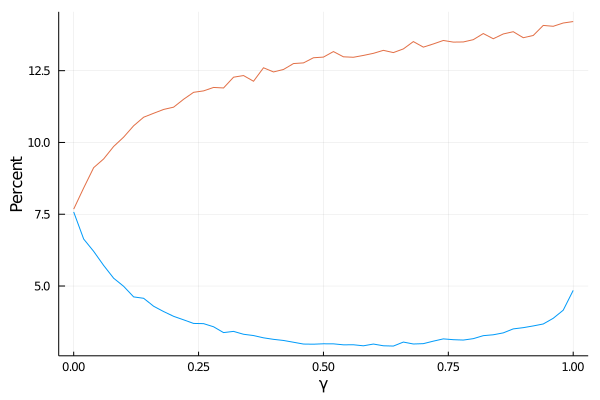

In [16]:
Random.seed!(2)

γ_grid = LinRange(0,1,51)
T1_grid = zeros(length(γ_grid))
TX_grid = zeros(length(γ_grid))
for i in 1:length(γ_grid) 
    sell_times, sell_values = simulate_auction(n_sims,γ_grid[i],δ,G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csγ = plot(γ_grid,T1_grid,xlab="γ",ylab="Percent",legend=:false)
csγ = plot!(γ_grid,TX_grid)

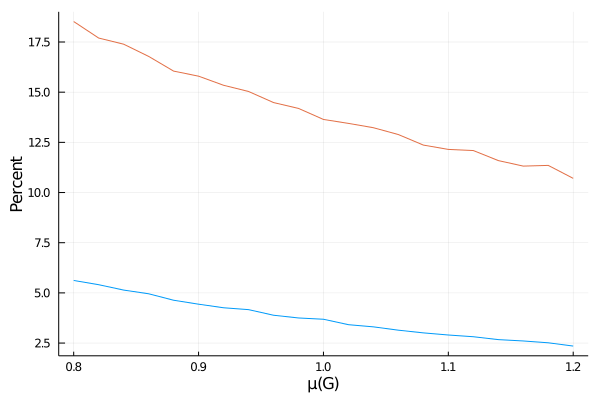

In [17]:
Random.seed!(2)
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

μG_grid = LinRange(0.8,1.2,21)
T1_grid = zeros(length(μG_grid))
TX_grid = zeros(length(μG_grid))
for i in 1:length(μG_grid) 
    G = Normal(μG_grid[i],0.2)
    sell_times, sell_values = simulate_auction(n_sims,γ,δ,G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csμG = plot(μG_grid,T1_grid,xlab="μ(G)",ylab="Percent",legend=:false)
csμG = plot!(μG_grid,TX_grid)

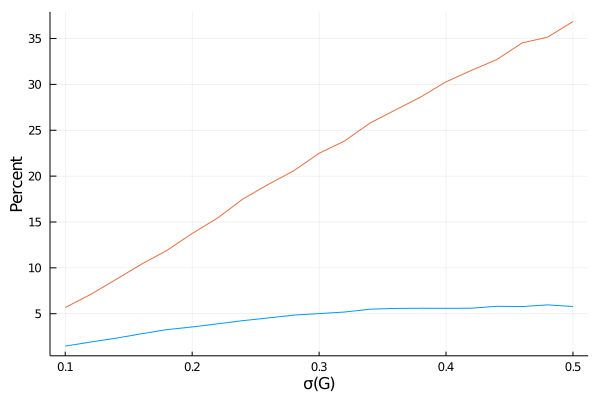

In [18]:
Random.seed!(2)
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

σG_grid = LinRange(0.1,0.5,21)
T1_grid = zeros(length(σG_grid))
TX_grid = zeros(length(σG_grid))
for i in 1:length(σG_grid) 
    G = Normal(1.0,σG_grid[i])
    sell_times, sell_values = simulate_auction(n_sims,γ,δ,G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csσG = plot(σG_grid,T1_grid,xlab="σ(G)",ylab="Percent",legend=:false)
csσG = plot!(σG_grid,TX_grid)

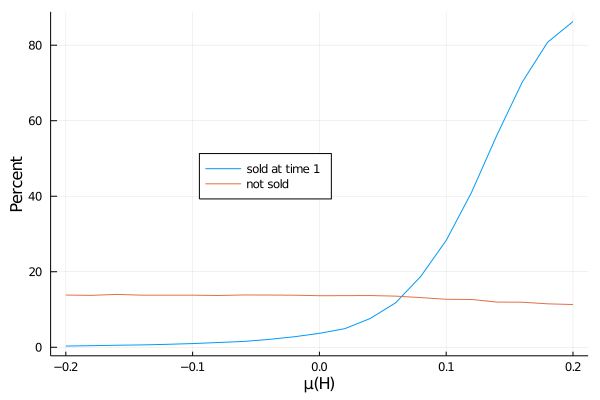

In [19]:
Random.seed!(2)
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

μH_grid = LinRange(-0.2,0.2,21)
T1_grid = zeros(length(μH_grid))
TX_grid = zeros(length(μH_grid))
for i in 1:length(μH_grid) 
    H = Normal(μH_grid[i],0.2)
    sell_times, sell_values = simulate_auction(n_sims,γ,δ,G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csμH = plot(μH_grid,T1_grid,xlab="μ(H)",ylab="Percent",label="sold at time 1",legend=:inside)
csμH = plot!(μH_grid,TX_grid,label="not sold")

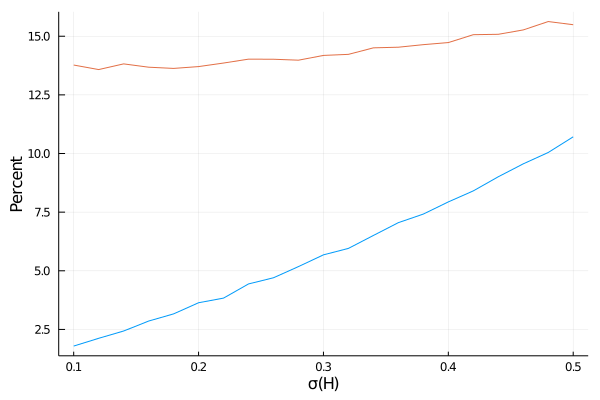

In [20]:
Random.seed!(2)
G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

σH_grid = LinRange(0.1,0.5,21)
T1_grid = zeros(length(σH_grid))
TX_grid = zeros(length(σH_grid))
for i in 1:length(σH_grid) 
    H = Normal(0.0,σH_grid[i])
    sell_times, sell_values = simulate_auction(n_sims,γ,δ,G,H,M)
    T1_grid[i] = length(findall(sell_times.==1))*100/n_sims
    TX_grid[i] = length(findall(sell_times.==-1))*100/n_sims
end
csσH = plot(σH_grid,T1_grid,xlab="σ(H)",ylab="Percent",legend=:false)
csσH = plot!(σH_grid,TX_grid)

In [21]:
l = @layout [ a b ; c d ; e f ]
plot(csδ,csγ,csμG,csσG,csμH,csσH,layout=l)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N1T1simcs.png")

## Two Bidders - Value Function

In [22]:
function invhaz_multi(D,x)
    n = length(x)
    ih = zeros(n)
    for i in 1:n
        ih[i] = invhaz(D[i],x[i])
    end
    return ih
end

function V1_two(θ1,θ0,γ,δ,G,H,M)
    ψ0 = invhaz_multi(G,θ0)
    sell_value = maximum(θ1.-ψ0*γ)
    value = max(sell_value,0)
    return value
end

function V0_two(θ0,γ,δ,G,H,M)
    ψ0 = invhaz_multi(G,θ0)
    α, ω = gausshermite(M)
    sell_value = maximum(θ0.-ψ0)
    wait_value = 0
    for i in 1:M
        for j in 1:M
            y = [γ*θ0[1]+sqrt(2)*std(H[1])*α[i],γ*θ0[2]+sqrt(2)*std(H[2])*α[j]]
            wait_value = wait_value+ω[i]*ω[j]*V1_two(y,θ0,γ,δ,G,H,M)
        end
    end
    wait_value = δ*wait_value/π
    value = max(sell_value,wait_value)
    return value
end

V0_two (generic function with 1 method)

In [23]:
γ = 0.6
δ = 0.9

G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

M = 21

21

In [24]:
θ0_1_grid = LinRange(0.0,2.0,201)
θ0_2_grid = LinRange(0.0,2.0,201)
V0_grid = zeros(length(θ0_1_grid),length(θ0_2_grid))
for i in 1:length(θ0_1_grid)
    for j in 1:length(θ0_2_grid)
        V0_grid[i,j] = V0_two([θ0_1_grid[i],θ0_2_grid[j]],γ,δ,G,H,M)
    end
end
plot(θ0_1_grid,θ0_2_grid,V0_grid,st=:surface)

α, ω = gausshermite(M)
EV = 0
for i in 1:M
    for j in 1:M
        y = [mean(G[1])+sqrt(2)*std(G[1])*α[i],mean(G[2])+sqrt(2)*std(G[2])*α[j]]
        EV = EV+ω[i]*ω[j]*V0_two(y,γ,δ,G,H,M)
    end
end
EV = EV/π

fV0_grid = zeros(length(θ0_1_grid),length(θ0_2_grid))
for i in 1:length(θ0_1_grid)
    for j in 1:length(θ0_2_grid)
        fV0_grid[i,j] = pdf(G[1],θ0_1_grid[i])*pdf(G[2],θ0_2_grid[j])*V0_grid[i,j]
    end
end

print("quad: ",EV,"\n")
print("trap: ",trapz((θ0_1_grid,θ0_2_grid),fV0_grid))
plot(θ0_1_grid,θ0_2_grid,V0_grid,title="Value Function",xlab="θ0_1",ylab="θ0_2",zlab="V0",st=:surface)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N2T1.png")

quad: 0.8964518458782997
trap: 0.9000462956286972

## Two Bidders - Simulate Auction

In [25]:
function simulate_auction_two(n_sims,γ,δ,G,H,M)
    sell_times = zeros(n_sims)
    sell_agents = zeros(n_sims)
    sell_values = zeros(n_sims)
    for i in 1:n_sims
        θ0 = [rand(G[1],1)[1],rand(G[2],1)[1]]
        ψ0 = invhaz_multi(G,θ0)
        α, ω = gausshermite(M)
        sell_agent = argmax(θ0.-ψ0)
        sell_value = maximum(θ0.-ψ0)
        wait_value = 0
        for k in 1:M
            for l in 1:M
                y = [γ*θ0[1]+mean(H[1])+sqrt(2)*std(H[1])*α[k],γ*θ0[2]+mean(H[2])+sqrt(2)*std(H[2])*α[l]]
                wait_value = wait_value+ω[k]*ω[l]*V1_two(y,θ0,γ,δ,G,H,M)
            end
        end
        wait_value = δ*wait_value/π
        if sell_value > wait_value
            sell_times[i] = 0
            sell_agents[i] = sell_agent
            sell_values[i] = sell_value
        else
            θ1 = γ*θ0+[rand(H[1],1)[1],rand(H[2],1)[1]]
            sell_values[i] = δ*V1_two(θ1,θ0,γ,δ,G,H,M)
            if (sell_values[i] != 0)
                sell_times[i] = 1
                sell_agents[i] = argmax(θ1.-ψ0*γ)
            else
                sell_times[i] = -1
                sell_agents[i] = -1
            end
        end
    end
    return sell_times, sell_agents, sell_values
end

simulate_auction_two (generic function with 1 method)

In [26]:
Random.seed!(1)

n_sims = 200000
sell_times, sell_agents, sell_values = simulate_auction_two(n_sims,γ,δ,G,H,M)

sell_values_0 = sell_values[findall(sell_times.==0)]
sell_values_1 = sell_values[findall(sell_times.!=0)]

print(mean(sell_values),"\n")
print(length(sell_values_1)/n_sims,"\n")
print(length(findall(sell_agents.==1))/n_sims,"\n")

histogram(sell_values_0,bins=50,title="Revenue Distribution",xlab="Revenue",ylab="Frequency",label="sold at t=0")
histogram!(sell_values_1,bins=20,label="sold at t=1 or not sold")
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N2T1sim.png")

0.899355726902291
0.027555
0.48955


## Two Bidders - Comparative Statics - Simulate Auction

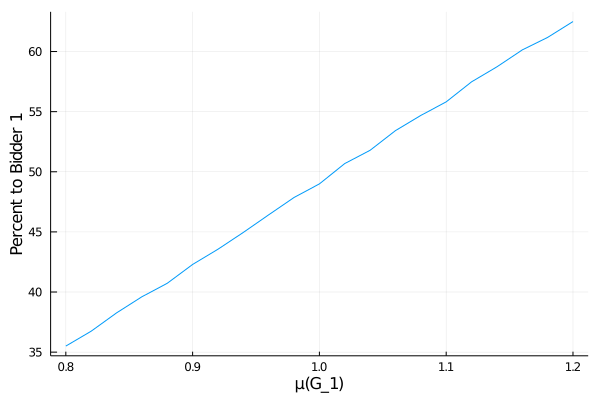

In [27]:
Random.seed!(2)
G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

μG_grid = LinRange(0.8,1.2,21)
N1_grid = zeros(length(μG_grid))
for i in 1:length(μG_grid) 
    G1 = Normal(μG_grid[i],0.2)
    G = [G1,G2]
    sell_times, sell_agents, sell_values = simulate_auction_two(n_sims,γ,δ,G,H,M)
    N1_grid[i] = length(findall(sell_agents.==1))*100/n_sims
end
csμG = plot(μG_grid,N1_grid,xlab="μ(G_1)",ylab="Percent to Bidder 1",legend=:false)

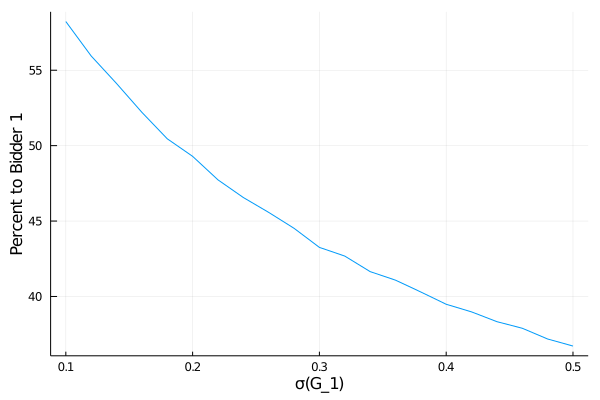

In [28]:
Random.seed!(2)
G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

σG_grid = LinRange(0.1,0.5,21)
N1_grid = zeros(length(σG_grid))
for i in 1:length(σG_grid) 
    G1 = Normal(1.0,σG_grid[i])
    G = [G1,G2]
    sell_times, sell_agents, sell_values = simulate_auction_two(n_sims,γ,δ,G,H,M)
    N1_grid[i] = length(findall(sell_agents.==1))*100/n_sims
end
csσG = plot(σG_grid,N1_grid,xlab="σ(G_1)",ylab="Percent to Bidder 1",legend=:false)

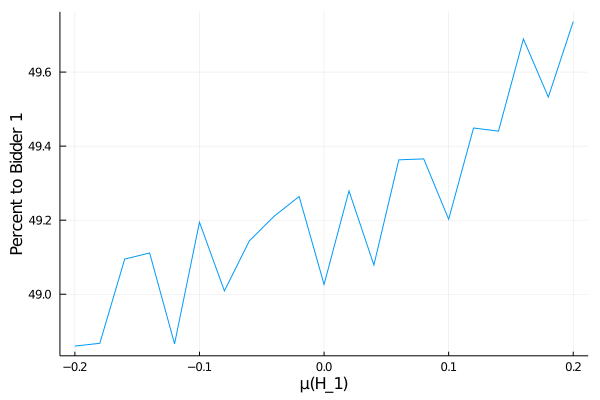

In [29]:
Random.seed!(2)
G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

μH_grid = LinRange(-0.2,0.2,21)
N1_grid = zeros(length(μH_grid))
for i in 1:length(μH_grid) 
    H1 = Normal(μH_grid[i],0.2)    
    H = [H1,H2]
    sell_times, sell_agents, sell_values = simulate_auction_two(n_sims,γ,δ,G,H,M)
    N1_grid[i] = length(findall(sell_agents.==1))*100/n_sims
end
csμH = plot(μH_grid,N1_grid,xlab="μ(H_1)",ylab="Percent to Bidder 1",legend=:false)

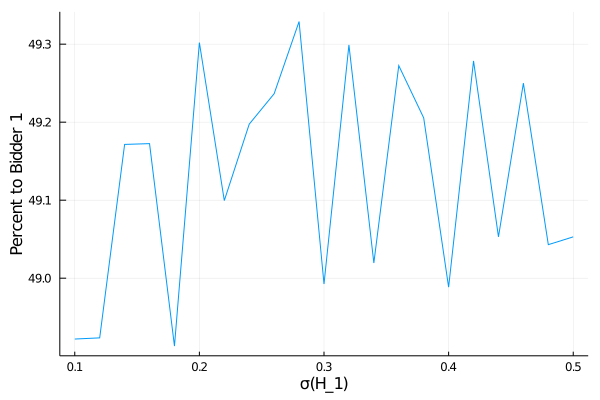

In [30]:
Random.seed!(2)
G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

σH_grid = LinRange(0.1,0.5,21)
N1_grid = zeros(length(σH_grid))
for i in 1:length(σH_grid) 
    H1 = Normal(0.0,σH_grid[i])
    H = [H1,H2]
    sell_times, sell_agents, sell_values = simulate_auction_two(n_sims,γ,δ,G,H,M)
    N1_grid[i] = length(findall(sell_agents.==1))*100/n_sims
end
csσH = plot(σH_grid,N1_grid,xlab="σ(H_1)",ylab="Percent to Bidder 1",legend=:false)

In [31]:
l = @layout [ a b ; c d ]
plot(csμG,csσG,csμH,csσH,layout=l)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/N2T1simcs.png")

## Many Bidders - Value Function

In [32]:
function invhaz_multi(D,x)
    n = length(x)
    ih = zeros(n)
    for i in 1:n
        ih[i] = invhaz(D[i],x[i])
    end
    return ih
end

function V1_many(θ1,θ0,N,γ,δ,G,H)
    ψ0 = invhaz_multi(G,θ0)
    sell_value = maximum(θ1.-ψ0*γ)
    value = max(sell_value,0)
    return value
end

function V0_many(θ0,N,γ,δ,G,H;n_sims=10000)
    ψ0 = invhaz_multi(G,θ0)
    sell_value = maximum(θ0.-ψ0)
    wait_value = 0
    for i in 1:n_sims
        θ1_sim = zeros(N)
        for j in 1:N
            θ1_sim[j] = γ*θ0[j]+rand(H[j],1)[1]
        end
        wait_value = wait_value+V1_many(θ1_sim,θ0,N,γ,δ,G,H)/n_sims
    end
    wait_value = δ*wait_value
    value = max(sell_value,wait_value)
    return value
end

V0_many (generic function with 1 method)

In [33]:
Random.seed!(1)

γ = 0.9
δ = 0.95
M = 21

N_grid = collect(1:10)
EV_grid = zeros(length(N_grid))
for i in 1:length(N_grid)
    G = Array{Normal{Float64}}(undef,N_grid[i])
    H = Array{Normal{Float64}}(undef,N_grid[i])
    for i in 1:N_grid[i]
        G[i] = Normal(1.0,0.2)
        H[i] = Normal(0.0,0.2)
    end
    n_sims = 10000
    V0s = zeros(n_sims)
    for k in 1:n_sims
        θ0 = zeros(N_grid[i])
        for l in 1:N_grid[i]
            θ0[l] = rand(G[l],1)[1]
        end
        V0s[k] = V0_many(θ0,N_grid[i],γ,δ,G,H)
    end
    EV_grid[i] = mean(V0s)
end

plot(N_grid,EV_grid,title="Optimal Expected Revenue",xlab="Number of Agents",ylab="E[V0]",legend=:false)
savefig("C:/Users/zhubr/Desktop/dynamic-auction/figures/NMT1.png")

In [34]:
EV_grid

10-element Array{Float64,1}:
 0.6781444461805215
 0.9021316770017797
 1.0000546945631097
 1.0627147872787504
 1.1019796286084114
 1.125245416021177
 1.154846632648926
 1.1734688475147508
 1.190250392113218
 1.2038065890891927

## Many Bidders - Simulate Auction

In [35]:
function simulate_auction_many(n_sims,N,γ,δ,G,H,M;n_sims_2=1000)
    sell_times = zeros(n_sims)
    sell_agents = zeros(n_sims)
    sell_values = zeros(n_sims)
    for i in 1:n_sims
        θ0 = zeros(N)
        for j in 1:N
            θ0[j] = rand(G[j],1)[1]
        end
        ψ0 = invhaz_multi(G,θ0)
        α, ω = gausshermite(M)
        sell_agent = argmax(θ0.-ψ0)
        sell_value = maximum(θ0.-ψ0)
        wait_value = 0
        V1s = zeros(n_sims_2)
        for k in 1:n_sims_2
            θ1 = zeros(N)
            for l in 1:N
                θ1[l] = γ*θ0[l]+rand(H[l],1)[1]
            end
            V1s[k] = δ*V1_many(θ1,θ0,N,γ,δ,G,H)
        end
        wait_value = mean(V1s)
        if sell_value > wait_value
            sell_times[i] = 0
            sell_agents[i] = sell_agent
            sell_values[i] = sell_value
        else
            θ1 = zeros(N)
            for j in 1:N
                θ1[j] = γ*θ0[j]+rand(H[j],1)[1]
            end
            sell_values[i] = δ*V1_many(θ1,θ0,γ,δ,G,H,M)
            if (sell_values[i] == 0) 
                sell_times[i] = -1
                sell_agents[i] = -1
            else
                sell_times[i] = 1
                sell_agents[i] = argmax(θ1.-ψ0*γ)
            end
        end
    end
    return sell_times, sell_agents, sell_values
end

simulate_auction_many (generic function with 1 method)

In [36]:
# sell_times, sell_agents, sell_values = simulate_auction_many(n_sims,N,γ,δ,G,H,M;n_sims_2=100)

# print(mean(sell_values),"\n")
# print(sum(sell_times)/n_sims,"\n")
# histogram(sell_values)